## Data exploration

In [1]:
# change theme of ipython notebooks
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

train_data = pd.read_csv('train.csv')
test_data= pd.read_csv('test.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
grouped = train_data.groupby(['Survived','Sex'])
grouped.size()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
dtype: int64

(-1.1164453720563676,
 1.2380220616415543,
 -1.1136825823952974,
 1.2677977688292619)

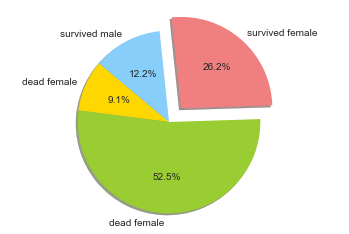

In [5]:
labels = 'dead female', 'dead female', 'survived female', 'survived male'
sizes = [81, 468, 233, 109]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0.2, 0)  # explode 2st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')

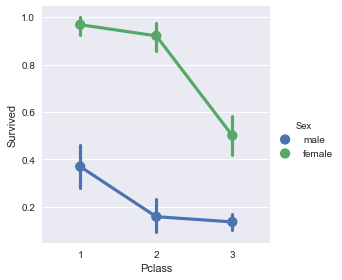

In [7]:
sns.factorplot('Pclass','Survived', data=train_data,hue='Sex')

## Data preprocessing
1. fill missing value in age
2. encode sex to numerical values
3. drop nonsense data

In [8]:
def get_median_ages(df):
    median_ages = np.zeros((2,3))

    for j in range(0, 3):
        median_ages[0,j] = df[(df['Sex'] == 'female') & \
                              (df['Pclass'] == j+1)]['Age'].dropna().median()
        median_ages[1,j] = df[(df['Sex'] == 'male') & \
                              (df['Pclass'] == j+1)]['Age'].dropna().median()
    return median_ages

median_ages = get_median_ages(train_data)
median_ages   # female is yonger than male, upper class is older than lower class

array([[ 35. ,  28. ,  21.5],
       [ 40. ,  30. ,  25. ]])

In [43]:
def data_clean(df, median_ages):

    df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # use median age to fill the missing data
    for i in range(0, 2):
        for j in range(0, 3):
              df.loc[ (df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1),\
                    'Age'] = median_ages[i,j]
    
    droplist = ['Name','Ticket','Cabin','Embarked','Sex'] # reserve ID for check
    features = df.drop(droplist, axis = 1)
    return features

In [44]:
train_cleaned = data_clean(train_data,median_ages)
features = train_cleaned.drop(['PassengerId','Survived'],axis=1)
labels = train_data ['Survived']

## Feature importance
This is an attribute only availble to decision tree model. As expected, gender, fare and age are the top 3 important features.

Note: the base-line benchmark, predicts all females survive, have a accuracy of 78.68%

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(
    features, labels, test_size=0.3, random_state=0)
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier()
clf.fit(X_train,y_train)
from sklearn.metrics import accuracy_score,fbeta_score

pred=clf.predict(X_test)
print accuracy_score(y_test, pred) 

0.80223880597


In [45]:
def feature_plot(importances, X_train):   
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12) 
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

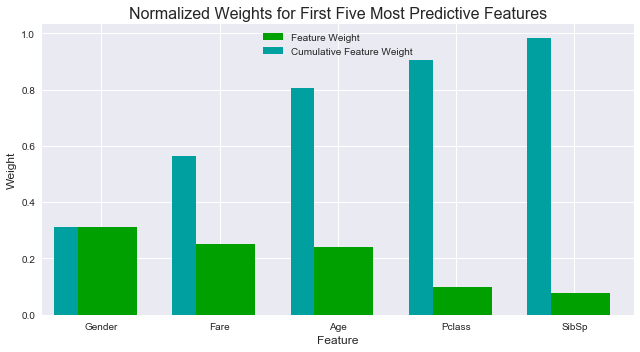

In [48]:
feature_plot(clf.feature_importances_,X_train)

## learning curves

In [49]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

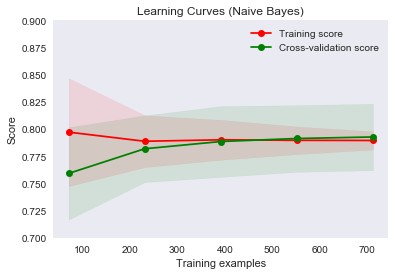

In [52]:
X, y = features, labels
title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
from sklearn.naive_bayes import GaussianNB
plot_learning_curve(GaussianNB(), title, X, y, ylim=(0.7, 0.9), cv=cv, n_jobs=4)
plt.show()

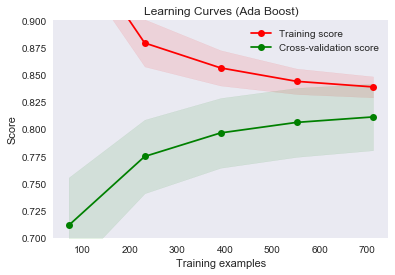

In [55]:
title = "Learning Curves (Ada Boost)"
from sklearn.ensemble import AdaBoostClassifier
plot_learning_curve(AdaBoostClassifier(), title, X, y, ylim=(0.7, 0.9), cv=cv, n_jobs=4)
plt.show()

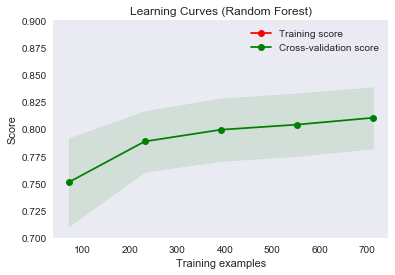

In [56]:
title = "Learning Curves (Random Forest)"
from sklearn.ensemble import RandomForestClassifier
plot_learning_curve(RandomForestClassifier(), title, X, y, ylim=(0.7, 0.9), cv=cv, n_jobs=4)
plt.show()

## validation curves

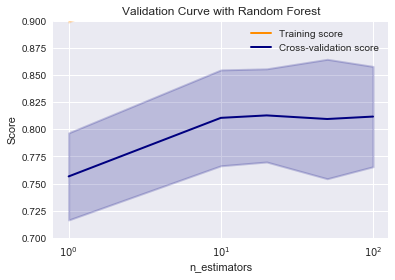

In [58]:
from sklearn.model_selection import validation_curve
param_range=[1,10,20,50,100]
train_scores, test_scores = validation_curve(
    RandomForestClassifier(), X, y, param_name="n_estimators", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.7, 0.9)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

**conclusion**: It depends on your luck, which is 0.75~0.85

## Predict on unseen data

In [61]:

cleaned = data_clean(test_data,median_ages)
X_test = cleaned.drop(['PassengerId'],axis=1)
X_test = features.fillna(method = 'backfill')
X_test.info()

clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(X,y)
pred = clf.predict(X_test)
submission = pd.DataFrame({'PassengerId':test_data['PassengerId'],'Survived':pred})
submission.groupby('Survived').count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
Pclass    418 non-null int64
Age       418 non-null float64
SibSp     418 non-null int64
Parch     418 non-null int64
Fare      418 non-null float64
Gender    418 non-null int64
dtypes: float64(2), int64(4)
memory usage: 19.7 KB


,PassengerId
Survived,
0,269
1,149


In [62]:
submission.to_csv('titanic.csv',index=False)

### submit history
1. on 2017-1-1, score 0.7461 at rank 5358 
2. worse
3. score 0.7655 at rank 4759, benchmark of gender based model
4. score 0.77033 at rank 3864, use MLND, hand-craft algorithm
5. score 0.78469 at rank 2583, benchmark of gender-class-fare based model
6. no improvement
7. 2017-2-9, no improvement

### human learning approach
hand pick rules

In [237]:
def myClassifier(df):
    length = df.shape[0]
    pred= [0 for _ in range(length)]
    for i in range (length):
        if df.loc[i,'Sex'] == 'female':
            if df.loc[i,'Pclass'] == 1 or df.loc[i,'Pclass'] == 2:
                pred[i] = 1
            if df.loc[i,'Pclass'] == 3 and df.loc[i,'Fare'] <= 20:
                pred[i] = 1
        elif df.loc[i,'Age'] <= 15 and df.loc[i,'Pclass'] <= 2:
            pred[i] = 1
    return pred

y_test = train_data['Survived']
pred = myClassifier(train_data)
print accuracy_score(y_test, pred)

0.821548821549
